## _*H2 energy with various RY and RYRZ variational forms*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule using VQE with different variation form configurations. The results are compared to the same energy as computed by the ExactEigensolver 

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RYRZ, RY
from qiskit.aqua.components.initial_states import Zero
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

var_forms = [RYRZ, RY]
entanglements = ['full', 'linear']
depths = [x for x in range(3, 11)]

energies = np.empty([len(var_forms), len(entanglements), len(depths)])
hf_energy = None
energy = None
eval_counts = np.empty([len(var_forms), len(entanglements), len(depths)])

aqua_globals.random_seed = 50

driver = PySCFDriver('H .0 .0 -0.3625; H .0 .0 0.3625', basis='sto3g')
qmolecule = driver.run()
operator =  Hamiltonian(qubit_mapping=QubitMappingType.JORDAN_WIGNER, two_qubit_reduction=False)
qubit_op, aux_ops = operator.run(qmolecule)
result = ExactEigensolver(qubit_op).run()
lines, result = operator.process_algorithm_result(result)
    
hf_energy = result['hf_energy']
energy = result['energy']
print('Hartree-Fock energy:', hf_energy)
print('FCI energy:', energy)

Couldn't find cython int routine
Couldn't find cython int routine
Hartree-Fock energy: -1.1173432691225826
FCI energy: -1.1372213770723036


With a reference FCI energy computed from ExactEigensolver we now compute the ground state energy with VQE and different variational form setups

In [2]:
print('Processing step __', end='')
for i, d in enumerate(depths):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    for j in range(len(entanglements)):
        for k in range(len(var_forms)):
            variational_form_cls = var_forms[k] 
        
            driver = PySCFDriver('H .0 .0 -0.3625; H .0 .0 0.3625', basis='sto3g')
            qmolecule = driver.run()
            operator =  Hamiltonian(qubit_mapping=QubitMappingType.JORDAN_WIGNER, two_qubit_reduction=False)
            qubit_op, aux_ops = operator.run(qmolecule)
            optimizer = COBYLA(maxiter=10000)
            initial_state = Zero(qubit_op.num_qubits)
            var_form = variational_form_cls(qubit_op.num_qubits, depth=d, entanglement=entanglements[j])
            algo = VQE(qubit_op, var_form, optimizer)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                seed_simulator=aqua_globals.random_seed,
                                seed_transpiler=aqua_globals.random_seed))
            lines, result = operator.process_algorithm_result(result)

            energies[k][j][i] = result['energy']
            eval_counts[k][j][i] = result['algorithm_retvals']['eval_count']
print(' --- complete')

print('Depths: ', depths)
print('Energies:', energies)
print('Num evaluations:', eval_counts)

Processing step  7 --- complete
Depths:  [3, 4, 5, 6, 7, 8, 9, 10]
Energies: [[[-1.11734327 -1.13722081 -1.13721108 -1.13722132 -1.13722135
   -1.13722136 -1.13722137 -1.13722137]
  [-1.13722126 -1.13715666 -1.13710786 -1.13713713 -1.13719082
   -1.13719931 -1.13721934 -1.13722091]]

 [[-1.13722077 -1.13722071 -1.13722029 -1.13722135 -1.13722135
   -1.13722136 -1.13722137 -1.13722137]
  [-1.13722136 -1.13722135 -1.13722125 -1.13722137 -1.13722137
   -1.13722137 -1.13722138 -1.13722137]]]
Num evaluations: [[[  775. 10000. 10000.  7834.  5025.  2980.  2781.  3441.]
  [ 8586. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]]

 [[ 2913.  4795.  7154.  1033.   943.  1186.   923.  1045.]
  [  810.  1484.  2594.   552.   620.   703.   687.   878.]]]


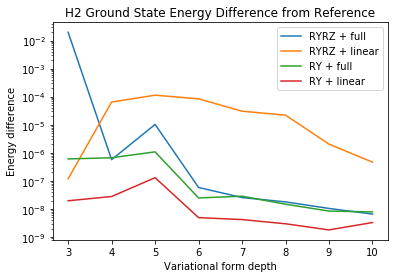

In [3]:
for k in range(len(var_forms)):
    for j in range(len(entanglements)):
        pylab.plot(depths, energies[k][j]-energy, label=var_forms[k].__name__+' + '+entanglements[j])
pylab.xlabel('Variational form depth')
pylab.ylabel('Energy difference')
pylab.yscale('log')
pylab.title('H2 Ground State Energy Difference from Reference')
pylab.legend(loc='upper right');

The above plot shows how close the ground state energy result from VQE was to the reference. The next plot shows how many evaluations (calls to the objective/cost function) were needed by the optimizer before it stopped and returned. Note that the optimzer was configured with a maximum number of iterations of 10,000. The COBYLA optimizer makes one evaluation per iteration and it can be seen that for some points that the iteration limit was reached which caused the optimizer to return.

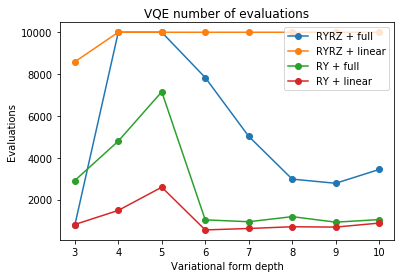

In [4]:
for k in range(len(var_forms)):
    for j in range(len(entanglements)):
        pylab.plot(depths, eval_counts[k][j], '-o', label=var_forms[k].__name__+' + '+entanglements[j])
pylab.xlabel('Variational form depth')
pylab.ylabel('Evaluations')
pylab.title('VQE number of evaluations')
pylab.legend(loc='upper right');